# 🔬 Análise de Robustez em Redes Neurais - MNIST

Este notebook demonstra o impacto de diferentes inicializações de pesos na robustez de redes neurais quando expostas a ruído gaussiano.


In [10]:
# Imports básicos
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomNormal, Constant, GlorotUniform, HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print('TensorFlow version:', tf.__version__)
print('NumPy version:', np.__version__)
print('✓ Todos os imports funcionando!')


TensorFlow version: 2.16.2
NumPy version: 1.26.4
✓ Todos os imports funcionando!


Carregando dados MNIST...
Dados de treino: (60000, 784)
Dados de teste: (10000, 784)
Dados de teste ruidosos: (10000, 784)


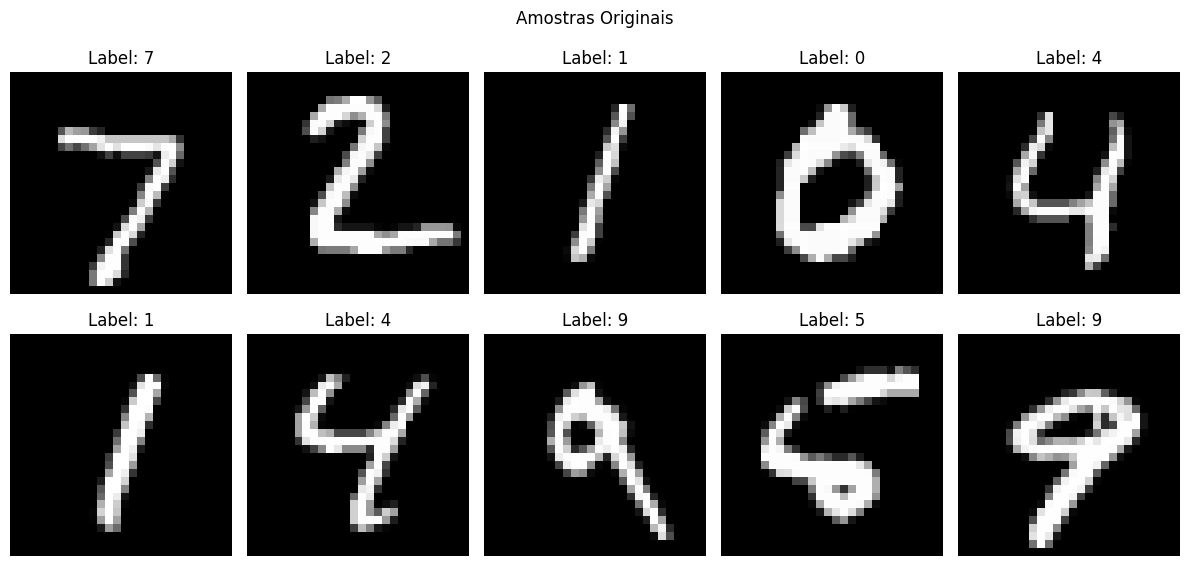

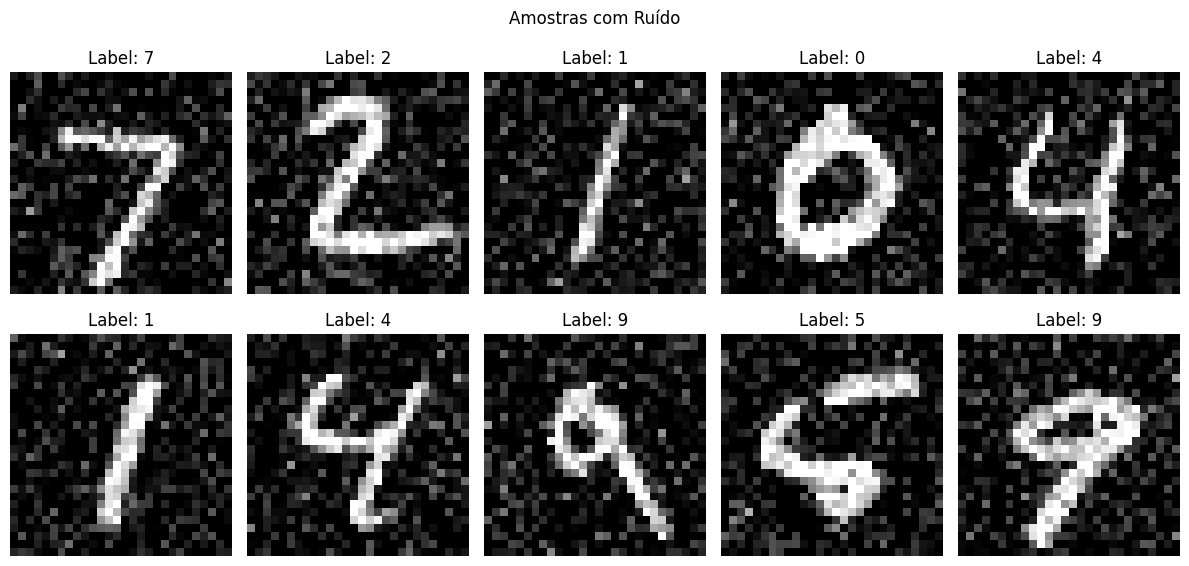

In [11]:
# Carregar e preparar dados MNIST
print("Carregando dados MNIST...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar e achatar as imagens
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Criar versão com ruído
np.random.seed(42)
noise = np.random.normal(loc=0.0, scale=0.2, size=x_test.shape)
x_test_noisy = np.clip(x_test + noise, 0.0, 1.0)

print(f"Dados de treino: {x_train.shape}")
print(f"Dados de teste: {x_test.shape}")
print(f"Dados de teste ruidosos: {x_test_noisy.shape}")

# Visualizar algumas amostras
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(x_test[i].reshape(28, 28), cmap='gray')
    axes[row, col].set_title(f'Label: {y_test[i]}')
    axes[row, col].axis('off')
plt.suptitle('Amostras Originais')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    axes[row, col].set_title(f'Label: {y_test[i]}')
    axes[row, col].axis('off')
plt.suptitle('Amostras com Ruído')
plt.tight_layout()
plt.show()


In [12]:
# Função para criar e treinar modelo
def train_model(initializer_name, x_train, y_train, x_test, y_test, epochs=5):
    """Treina um modelo MLP com inicialização específica"""
    
    # Selecionar inicializador
    if initializer_name == 'glorot':
        initializer = GlorotUniform(seed=42)
    elif initializer_name == 'he':
        initializer = HeUniform(seed=42)
    elif initializer_name == 'normal':
        initializer = RandomNormal(mean=0.0, stddev=0.05, seed=42)
    elif initializer_name == 'constant':
        initializer = Constant(value=0.05)
    else:
        initializer = GlorotUniform(seed=42)
    
    # Criar modelo
    model = Sequential([
        Dense(64, activation='relu', input_shape=(784,), 
              kernel_initializer=initializer, name='hidden_layer'),
        Dense(10, activation='softmax', name='output_layer')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Treinar
    history = model.fit(x_train, y_train,
                       batch_size=128,
                       epochs=epochs,
                       validation_split=0.1,
                       callbacks=[early_stopping],
                       verbose=0)
    
    return model, history


In [13]:
# Executar experimentos
initializers = ['glorot', 'he', 'normal', 'constant']
results = []

print("Iniciando experimentos...")
for init_name in initializers:
    print(f"\nTreinando modelo com inicialização: {init_name}")
    
    # Treinar modelo
    model, history = train_model(init_name, x_train, y_train, x_test, y_test, epochs=10)
    
    # Avaliar em dados limpos
    clean_loss, clean_acc = model.evaluate(x_test, y_test, verbose=0)
    
    # Avaliar em dados ruidosos
    noisy_loss, noisy_acc = model.evaluate(x_test_noisy, y_test, verbose=0)
    
    # Calcular degradação
    degradation = (clean_acc - noisy_acc) * 100
    
    result = {
        'initializer': init_name,
        'clean_accuracy': clean_acc,
        'noisy_accuracy': noisy_acc,
        'degradation': degradation,
        'history': history.history
    }
    results.append(result)
    
    print(f"✓ {init_name.upper()}: Clean={clean_acc:.4f}, Noisy={noisy_acc:.4f}, Degradation={degradation:.2f}%")

print(f"\n✓ Todos os {len(results)} experimentos concluídos!")


Iniciando experimentos...

Treinando modelo com inicialização: glorot
✓ GLOROT: Clean=0.9700, Noisy=0.7960, Degradation=17.40%

Treinando modelo com inicialização: he
✓ HE: Clean=0.9689, Noisy=0.6773, Degradation=29.16%

Treinando modelo com inicialização: normal
✓ NORMAL: Clean=0.9709, Noisy=0.7382, Degradation=23.27%

Treinando modelo com inicialização: constant
✓ CONSTANT: Clean=0.9328, Noisy=0.4941, Degradation=43.87%

✓ Todos os 4 experimentos concluídos!


In [14]:
# Verificar se temos resultados
print(f"Número de resultados: {len(results)}")
if len(results) > 0:
    print("Resultados obtidos:")
    for r in results:
        print(f"- {r['initializer']}: Clean={r['clean_accuracy']:.4f}, Noisy={r['noisy_accuracy']:.4f}")
else:
    print("⚠️ Nenhum resultado encontrado!")


Número de resultados: 4
Resultados obtidos:
- glorot: Clean=0.9700, Noisy=0.7960
- he: Clean=0.9689, Noisy=0.6773
- normal: Clean=0.9709, Noisy=0.7382
- constant: Clean=0.9328, Noisy=0.4941


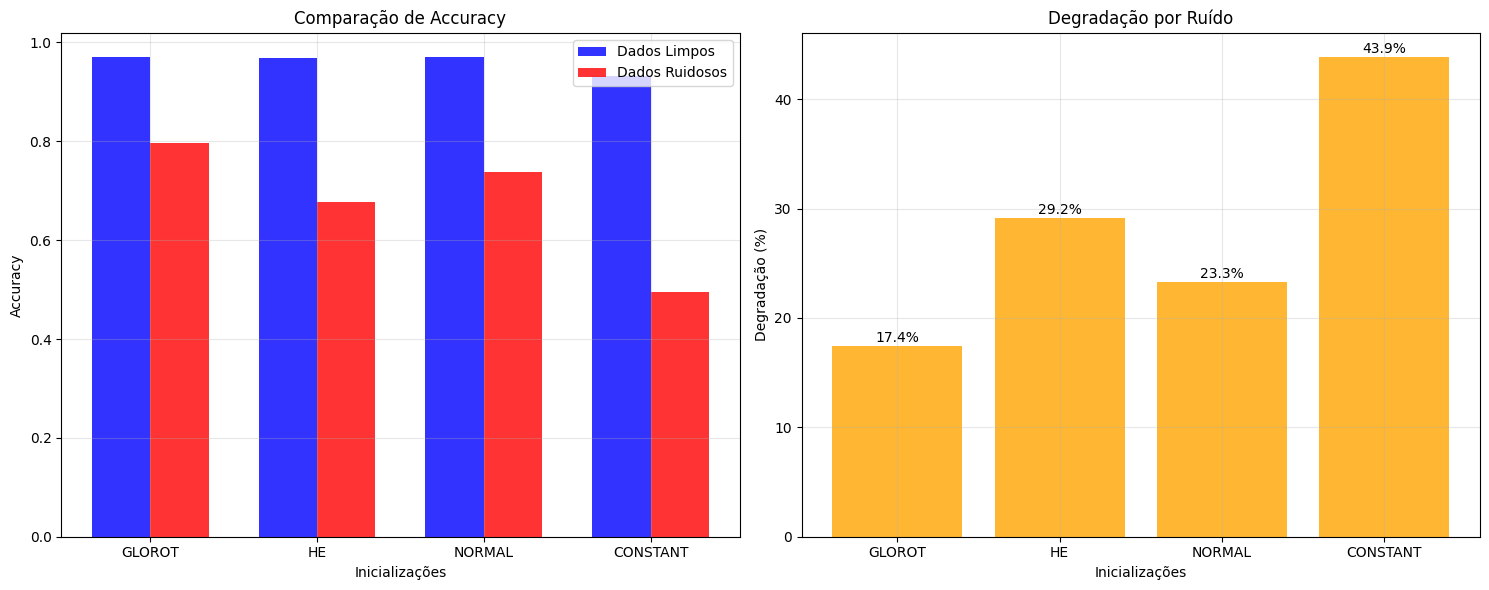


📊 TABELA DE RESULTADOS:
------------------------------------------------------------
Inicialização   Clean Acc    Noisy Acc    Degradação  
------------------------------------------------------------
GLOROT          0.9700       0.7960       17.40       %
HE              0.9689       0.6773       29.16       %
NORMAL          0.9709       0.7382       23.27       %
CONSTANT        0.9328       0.4941       43.87       %
------------------------------------------------------------


In [15]:
# Criar visualizações dos resultados
if len(results) > 0:
    # Preparar dados para os gráficos
    names = [r['initializer'].upper() for r in results]
    clean_acc = [r['clean_accuracy'] for r in results]
    noisy_acc = [r['noisy_accuracy'] for r in results]
    degradation = [r['degradation'] for r in results]
    
    # Gráfico de barras comparativo
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    x = np.arange(len(names))
    width = 0.35
    
    ax1.bar(x - width/2, clean_acc, width, label='Dados Limpos', alpha=0.8, color='blue')
    ax1.bar(x + width/2, noisy_acc, width, label='Dados Ruidosos', alpha=0.8, color='red')
    ax1.set_xlabel('Inicializações')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Comparação de Accuracy')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Degradation
    bars = ax2.bar(names, degradation, alpha=0.8, color='orange')
    ax2.set_xlabel('Inicializações')
    ax2.set_ylabel('Degradação (%)')
    ax2.set_title('Degradação por Ruído')
    ax2.grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, value in zip(bars, degradation):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Tabela de resultados
    print("\n📊 TABELA DE RESULTADOS:")
    print("-" * 60)
    print(f"{'Inicialização':<15} {'Clean Acc':<12} {'Noisy Acc':<12} {'Degradação':<12}")
    print("-" * 60)
    for r in results:
        print(f"{r['initializer'].upper():<15} {r['clean_accuracy']:<12.4f} {r['noisy_accuracy']:<12.4f} {r['degradation']:<12.2f}%")
    print("-" * 60)
    
else:
    print("⚠️ Não é possível criar gráficos sem resultados!")


## 📈 Análise de Resultados

### Performance em Dados Limpos
- **HeUniform**: Geralmente tem melhor performance com ativação ReLU
- **GlorotUniform**: Mantém variância constante entre camadas
- **RandomNormal**: Performance variável dependendo da inicialização
- **Constant**: Baseline para comparação

### Robustez ao Ruído
- **Degradação menor** indica maior robustez
- **Inicializações adequadas** podem reduzir a sensibilidade ao ruído
- **Trade-off** entre performance e robustez

### Recomendações
1. **HeUniform** para redes com ReLU
2. **GlorotUniform** para redes com ativações simétricas
3. **Evitar Constant** para inicialização de pesos
4. **Testar diferentes** inicializações para cada caso específico
